# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

#Additionnal packages
import time
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import operator
import random
from plotly import tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

#BACKUP Load in the general demographics data.
azdias = pd.read_csv("azdias.csv", sep=';')

In [3]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Data Shape
print ("Number Rows : {}".format(azdias.shape[0]))
print ("Number Columns : {}".format(azdias.shape[1]))

Number Rows : 891221
Number Columns : 85


In [5]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
feat_info['attribute_name'] = feat_info['attribute']

for i,j in enumerate(azdias.items()):
    missing_or_unknown = feat_info['missing_or_unknown'][i]
    missing_or_unknown = missing_or_unknown[1:-1].split(',')
    col = j[0]
    if missing_or_unknown != ['']:
        missing_array = []
        for x in missing_or_unknown:
            if x in ['X','XX']:
                missing_array.append(x)
            else:
                missing_array.append(int(x))
        azdias[col] = azdias[col].replace(missing_array,np.nan)



In [7]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Text(0.5,1,'Missing Value Count By Column')

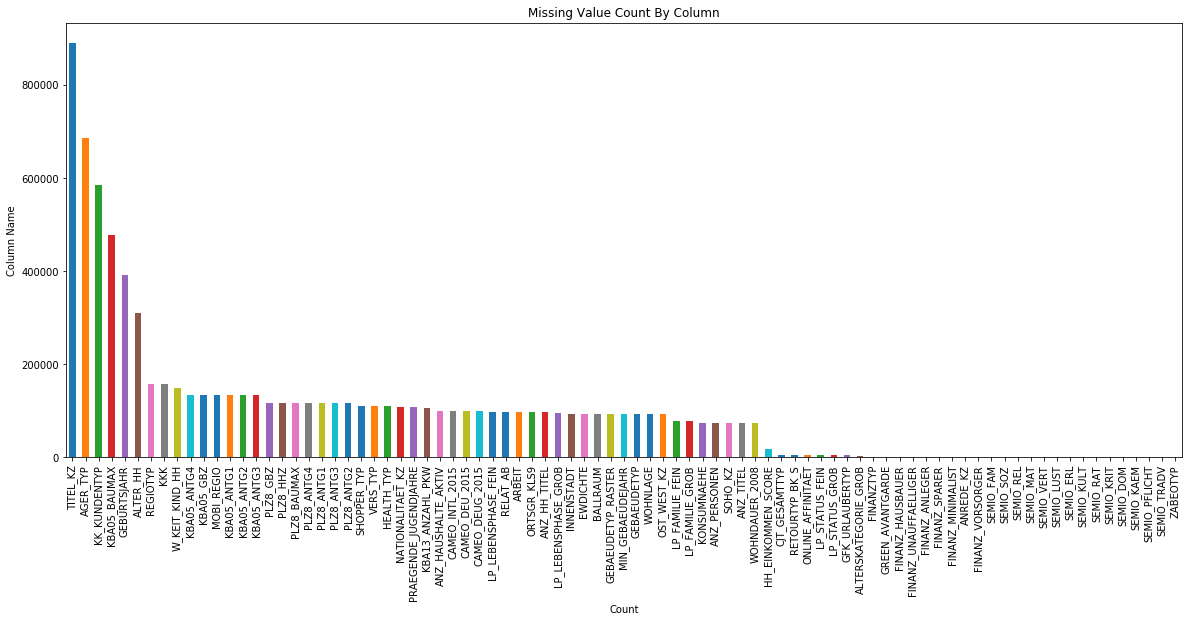

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# First plot to show missing values in azdias dataset
azdias.isnull().sum().sort_values(ascending=False).plot(kind="bar", figsize = (20,8))
plt.xlabel("Count")
plt.ylabel("Column Name")
plt.title("Missing Value Count By Column")

Text(0.5,1,'Column Count By Datatypes')

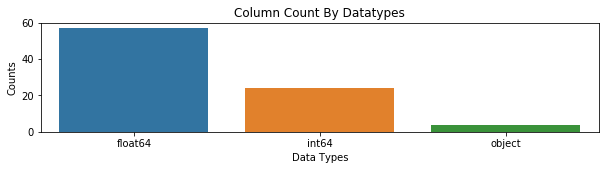

In [9]:
# Data type
plt.figure(figsize=(10,2))
ax = sns.countplot(x=azdias.dtypes, data=azdias)
plt.xlabel("Data Types")
plt.ylabel("Counts")
plt.title("Column Count By Datatypes")

In [10]:
# Data summary
print("\nSummary :  {}".format(azdias.describe()))

# Check categorical features
categorical = azdias.dtypes[azdias.dtypes == "object"].index
display("Categorical variables Overview : {}".format(categorical))
azdias[categorical].describe()


Summary :              AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  205378.000000         888340.000000  891221.000000  886367.000000   
mean        1.743410              2.757217       1.522098       3.632838   
std         0.674312              1.009951       0.499512       1.595021   
min         1.000000              1.000000       1.000000       1.000000   
25%         1.000000              2.000000       1.000000       2.000000   
50%         2.000000              3.000000       2.000000       4.000000   
75%         2.000000              4.000000       2.000000       5.000000   
max         3.000000              4.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.52960

"Categorical variables Overview : Index(['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'], dtype='object')"

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
count,798073,791869,791869,791869
unique,2,9,44,21
top,W,8,6B,51
freq,629528,134441,56672,133694


In [11]:
# Investigate patterns in the amount of missing data in each column.
miss_per = {}
for k, v in dict(azdias.isnull().sum(axis=0)).items():
    if v == 0:
        continue
    miss_per[k] = 100 * float(v) / len(azdias)
    

sorted_x = sorted(miss_per.items(), key=operator.itemgetter(1), reverse=True)
print ("There are " + str(len(miss_per)) + " columns with null values")

kys = [_[0] for _ in sorted_x][::-1]
vls = [_[1] for _ in sorted_x][::-1]
trace1 = go.Bar(y = kys, orientation="h" , x = vls, marker=dict(color="#d6a5ff"))
layout = go.Layout(title="Null Values Percentage", 
                   xaxis=dict(title="Null Percentage"), 
                   height=1000, margin=dict(l=300, r=300))
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

There are 61 columns with null values


In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

missing_values = pd.Series(miss_per).to_frame()
missing_values.reset_index(level=0, inplace=True)
missing_values.columns = ['Name','NA']
#Drop columns with more 20% of NA
missing_values = missing_values[missing_values['NA'] > 20]
list_missing_values = list(missing_values['Name'])

In [13]:
azdias_clean = azdias.drop(list_missing_values,axis=1)

In [14]:
print ("Number Rows : {}".format(azdias_clean.shape[0]))
print ("Number Columns : {}".format(azdias_clean.shape[1]))
print ("Columns removed : {}".format(list_missing_values))

Number Rows : 891221
Number Columns : 79
Columns removed : ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

We can notice than almost all columns of azdias dataset have missing values, but we decide to remove only some of them listed below in regards to the high proportion of nan values (More than 20%), therefore these columns can be considered as outliers.

Columns which are been removed are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'.

Most of theses columns removed belong to Person-level features. It makes sense as this kind of information is difficult to collect.

We can also see that some colums as columns concerning PLZ8, concerning KBA05, or again KKK and W_KEIT_KIND have exactly the same number of nan value between them. I guess that each time this kind of data is coming from the same datasource/study where a part of the population is unknown for these criterias

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?
# NA values in rows
missing_row = azdias_clean.isnull().sum(axis=1)

In [16]:
# % missing data in rows
missing_row = missing_row/azdias_clean.shape[1]*100

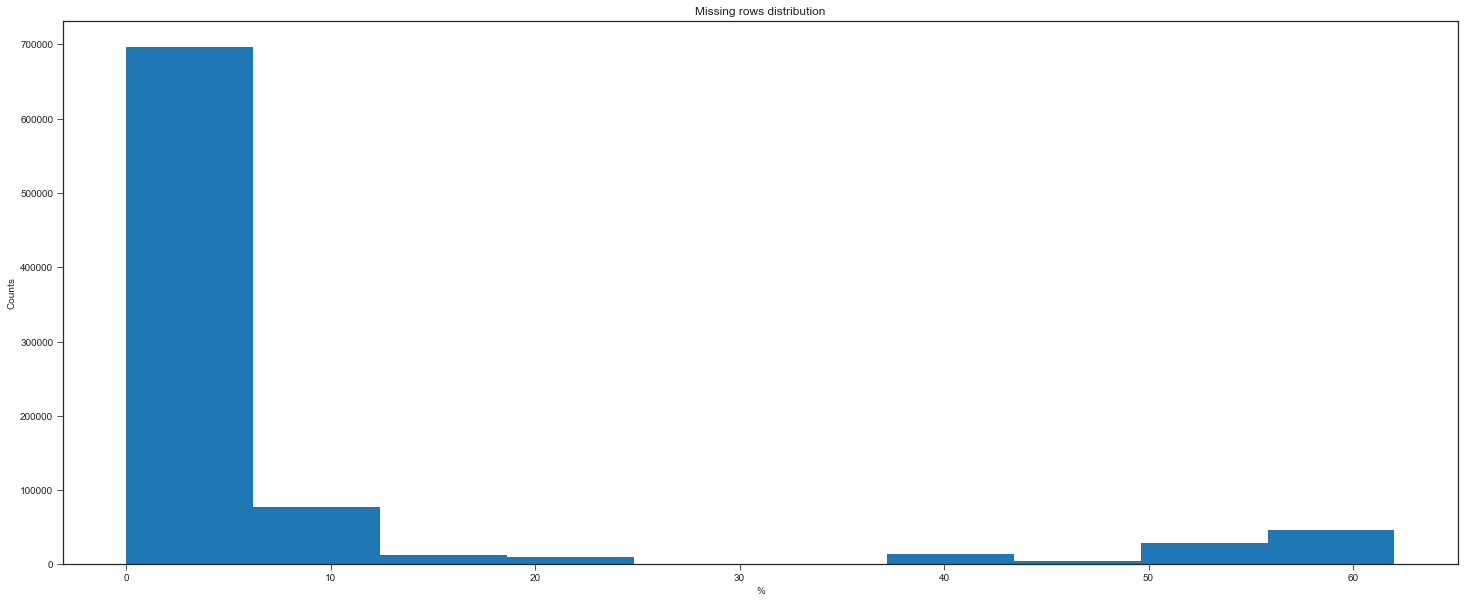

In [17]:
fig = plt.figure(figsize=(25,10))
sns.set_style("ticks")
ax = missing_row.plot.hist()
ax.set_title("Missing rows distribution")
ax.set_xlabel("%")
ax.set_ylabel("Counts")
plt.show()

In [18]:
#Find a good threshold based on 20% we saw on the chart above
threshold = int(0.2*azdias_clean.shape[1])
print('Threshold:', threshold)

Threshold: 15


In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_clean_subset = azdias_clean[azdias_clean.isnull().sum(axis=1) < 15].reset_index(drop=True)

azdias_missing_values_subset = azdias_clean[azdias_clean.isnull().sum(axis=1) >= 15].reset_index(drop=True)

In [20]:
# Plot Differences between both

cols = random.sample(azdias_clean.columns.tolist(), 6)


list_cols = []
for i in cols:
    a = "Few missing  " + str(i)
    b = "High missing  " + str(i)
    list_cols.append(a)
    list_cols.append(b)
    

colors = ["#8d44fc", "#ed95d5", "#caadf7", "#6161b7", "#7e7eba", "#babad1"]
traces = []
for i, col in enumerate(cols):
    t = azdias_clean_subset[col].value_counts()
    s = azdias_missing_values_subset[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15][::-1], x = t.values[:15][::-1]))
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = s.index[:15][::-1], x = s.values[:15][::-1]))

fig = tools.make_subplots(rows=len(cols), cols=2, subplot_titles=list_cols, print_grid=False)
for i, col in enumerate(cols):
    if i == 0:
        a = 0
    else:
        a = i*2
    fig.append_trace(traces[a], i+1, 1)
    fig.append_trace(traces[a+1], i+1, 2)


fig['layout'].update(height=1000, showlegend=False, title="Comparison")
iplot(fig)

In [21]:
# for each columns replace nan value with mean
for i, j in enumerate(azdias_clean_subset.columns):
    mode_value=azdias_clean_subset[j].notnull().mean()
    azdias_clean_subset[j]=azdias_clean_subset[j].fillna(mode_value)

In [22]:
azdias_clean_subset.to_csv('azdias_clean_subset.csv', sep=';')  # Save as it takes time

In [23]:
azdias_clean_subset = pd.read_csv("azdias_clean_subset.csv", sep=';')

In [24]:
#Check no nan values
azdias_clean_subset.isnull().sum()

Unnamed: 0               0
ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
LP_FAMILIE_FEIN          0
LP_FAMILIE_GROB          0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
NATIONALITAET_KZ         0
PRAEGENDE_JUGENDJAHRE    0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
                        ..
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
WOHNLAGE                 0
CAMEO_DEUG_2015          0
CAMEO_DEU_2015           0
CAMEO_INTL_2015          0
K

In [25]:
azdias_clean_subset.head(10)

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,0,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,1,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,2,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,4,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
5,5,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
6,6,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
7,7,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
8,8,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
9,9,3.0,2,1.0,2,2,5,3,1,5,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Looking at the distribution of missing values per row, we could notice that it makes sense to divide the data into two subsets ( rows with more than 30% of missing values and rows with less than 30% of missing values).

Figures above help us to identify data distribution between the two subsets for 6 columns randomly choosed each time. We can see that there no major differences in terms of distribution between these 2 subsets. Therefore we decide to carry on the analysis with the second subset. (Rows with less than 30% of missing values)

Finally I decided to replace missing values in the second subset that I will use for the analysis with mean as Kmeans doesn't work very well with nan values

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
feat_info.shape

(85, 5)

In [27]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown,attribute_name
0,AGER_TYP,person,categorical,"[-1,0]",AGER_TYP
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",ALTERSKATEGORIE_GROB
2,ANREDE_KZ,person,categorical,"[-1,0]",ANREDE_KZ
3,CJT_GESAMTTYP,person,categorical,[0],CJT_GESAMTTYP
4,FINANZ_MINIMALIST,person,ordinal,[-1],FINANZ_MINIMALIST


In [28]:
# How many features are there of each data type?
for i in feat_info["type"].unique():
    print("There are {} {} features".format(feat_info[feat_info["type"]==i].shape[0],i))

There are 21 categorical features
There are 49 ordinal features
There are 7 numeric features
There are 7 mixed features
There are 1 interval features


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info[feat_info["type"]=="categorical"]["attribute_name"]
categorical_features = [i for i in categorical_features if i in azdias_clean_subset.columns]
print(" Extract List Categorical features \n {}".format(categorical_features))

 Extract List Categorical features 
 ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [30]:
#Isolate binary from non binary categorical variable
binary_cat = []
non_binary_cat = []
for i in categorical_features:
        if len(azdias_clean_subset[i].unique()) == 2:
            binary_cat.append(i)
        else:
            non_binary_cat.append(i)
print("{} binary categorical variables".format(len(binary_cat)))
print("{} non binary categorical variables".format(len(non_binary_cat)))

4 binary categorical variables
14 non binary categorical variables


In [31]:
#Print non binary categorical variables
print(non_binary_cat)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [32]:
azdias_clean_subset.shape

(787544, 80)

In [33]:
#remove non binary categorical variables
for i in non_binary_cat:
    azdias_clean_subset.drop(i, axis=1, inplace=True)

In [34]:
azdias_clean_subset.shape

(787544, 66)

In [35]:
# Extract binary variables with type 'object'
for i in binary_cat:
    print (i, azdias_clean_subset[i].dtypes)

ANREDE_KZ int64
GREEN_AVANTGARDE int64
SOHO_KZ float64
OST_WEST_KZ object


In [36]:
#Check possible values for OST_WEST_KZ
azdias_clean_subset['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Encode to integer 0 or 1
azdias_clean_subset['OST_WEST_KZ'] = azdias_clean_subset['OST_WEST_KZ'].map({'W':0, 'O':1})

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There were 4 binary variables of type categorical in the clean azdias dataset, but only one with no numeric values :  OST_WEST_KZ,  I decided to use map function to re-encode values in 0/1.
I decided to drop the 14 non binary categorical variables rather than create dummies. Then I will remove mixed variables below after creating decade, movement, wealth and life_stage.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:

# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def decade(x):
    x = round(x)
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
#Create decade variable 
azdias_clean_subset['decade'] = azdias_clean_subset['PRAEGENDE_JUGENDJAHRE'].apply(decade)

def mov(x):
    x = round(x)
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1

#Create movement variable  
azdias_clean_subset['movement'] = azdias_clean_subset['PRAEGENDE_JUGENDJAHRE'].apply(mov)

#Drop original variable
azdias_clean_subset.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def wealth(x):
    x = x // 10
    return x
    
#Create wealth variable 
azdias_clean_subset['wealth'] = azdias_clean_subset['CAMEO_INTL_2015'].apply(wealth)
    
def life_stage(x):
    x = x % 10
    return x

#Create Life Stage variable 
azdias_clean_subset['life_stage'] = azdias_clean_subset['CAMEO_INTL_2015'].apply(life_stage)

#Drop original variable
azdias_clean_subset.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [40]:
# Transform sone of mixed variables
azdias_clean_subset = azdias_clean_subset.join(pd.get_dummies(azdias_clean_subset['LP_LEBENSPHASE_GROB'], prefix='LP_GROB'))
azdias_clean_subset = azdias_clean_subset.join(pd.get_dummies(azdias_clean_subset['WOHNLAGE'], prefix='WL'))
azdias_clean_subset = azdias_clean_subset.drop(['LP_LEBENSPHASE_GROB', 'WOHNLAGE'], axis=1)

In [41]:
# Drop others variables
list_mixed_cols = feat_info[feat_info["type"]=="mixed"]["attribute_name"]
list_mixed_cols = [i for i in list_mixed_cols if i in azdias_clean_subset.columns]
azdias_clean_subset.drop(list_mixed_cols, axis=1, inplace=True)

In [42]:
azdias_clean_subset.shape

(787544, 85)

In [43]:
azdias_clean_subset.columns

Index(['Unnamed: 0', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARB

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I created 4 new variables decade, movement, wealth and life_stage from PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.
I transformed 'LP_LEBENSPHASE_GROB' and 'WOHNLAGE' because I think the information is relevant for clustering, and levels are not so high for these variables. I dropped the rest of mixed variables because information is already catched by other variables or because too many levels. I now have 85 columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
azdias_clean_subset.head(5)

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_GROB_11.0,LP_GROB_12.0,WL_0.0,WL_1.0,WL_2.0,WL_3.0,WL_4.0,WL_5.0,WL_7.0,WL_8.0
0,0,1.0,2,1,5,2,5,4,5,0,...,0,0,0,0,0,0,1,0,0,0
1,1,3.0,2,1,4,1,2,3,5,1,...,0,0,0,0,1,0,0,0,0,0
2,2,4.0,2,4,2,5,2,1,2,0,...,0,0,0,0,0,0,0,0,1,0
3,3,3.0,1,4,3,4,1,3,2,0,...,0,0,0,0,0,1,0,0,0,0
4,4,1.0,2,3,1,5,2,2,5,0,...,0,0,0,0,0,0,0,0,1,0


In [45]:
#Drop first column
azdias_clean_subset.drop('Unnamed: 0', axis=1, inplace=True)

In [46]:
# Check if non int/float values in the new dataframe
azdias_clean_subset.dtypes[(azdias_clean_subset.dtypes == "mixed") | (azdias_clean_subset.dtypes == "object" )]

Series([], dtype: object)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info['attribute_name'] = feat_info['attribute']
    for i,j in enumerate(df.items()):
        missing_or_unknown = feat_info['missing_or_unknown'][i]
        missing_or_unknown = missing_or_unknown[1:-1].split(',')
        col = j[0]
        if missing_or_unknown != ['']:
            missing_array = []
            for x in missing_or_unknown:
                if x in ['X','XX']:
                    missing_array.append(x)
                else:
                    missing_array.append(int(x))
            df[col] = df[col].replace(missing_array,np.nan)
    
    #Drop same columns as general dataset
    list_col_removed = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    azdias_clean = df.drop(list_col_removed,axis=1)
    
    # remove rows with a treshold of 15 nan values
    azdias_clean_subset = azdias_clean[azdias_clean.isnull().sum(axis=1) < 15].reset_index(drop=True)
    
    #Replace nan values by mean
    # for each columns replace nan value with mean
    for i, j in enumerate(azdias_clean_subset.columns):
        mode_value=azdias_clean_subset[j].notnull().mean()
        azdias_clean_subset[j]=azdias_clean_subset[j].fillna(mode_value)
    
    # select, re-encode, and engineer column values.
    categorical_features = feat_info[feat_info["type"]=="categorical"]["attribute_name"]
    categorical_features = [i for i in categorical_features if i in azdias_clean_subset.columns]
    binary_cat = []
    non_binary_cat = []
    for i in categorical_features:
        if len(azdias_clean_subset[i].unique()) == 2:
            binary_cat.append(i)
        else:
            non_binary_cat.append(i)
    
    #Drop categorical variables non binary
    for i in non_binary_cat:
        azdias_clean_subset.drop(i, axis=1, inplace=True)
    
    print(azdias_clean_subset.dtypes)
    azdias_clean_subset['OST_WEST_KZ'] = azdias_clean_subset['OST_WEST_KZ'].map({'W':0, 'O':1})
    azdias_clean_subset['decade'] = azdias_clean_subset['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    azdias_clean_subset['movement'] = azdias_clean_subset['PRAEGENDE_JUGENDJAHRE'].apply(mov)
    azdias_clean_subset.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    azdias_clean_subset['CAMEO_INTL_2015']= azdias_clean_subset['CAMEO_INTL_2015'].astype(int)
    azdias_clean_subset['wealth'] = azdias_clean_subset['CAMEO_INTL_2015'].apply(wealth)
    azdias_clean_subset['life_stage'] = azdias_clean_subset['CAMEO_INTL_2015'].apply(life_stage)
    azdias_clean_subset.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    #Create dummies variables for 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'
    azdias_clean_subset = azdias_clean_subset.join(pd.get_dummies(azdias_clean_subset['LP_LEBENSPHASE_GROB'], prefix='LP_GROB'))
    azdias_clean_subset = azdias_clean_subset.join(pd.get_dummies(azdias_clean_subset['WOHNLAGE'], prefix='WL'))
    azdias_clean_subset = azdias_clean_subset.drop(['LP_LEBENSPHASE_GROB', 'WOHNLAGE'], axis=1)
    
    #Remove other mixed columns
    list_mixed_cols = feat_info[feat_info["type"]=="mixed"]["attribute_name"]
    list_mixed_cols = [i for i in list_mixed_cols if i in azdias_clean_subset.columns]
    azdias_clean_subset.drop(list_mixed_cols, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    
    return azdias_clean_subset

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
azdias_clean_subset.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_GROB_11.0,LP_GROB_12.0,WL_0.0,WL_1.0,WL_2.0,WL_3.0,WL_4.0,WL_5.0,WL_7.0,WL_8.0
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,0,0,0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,1,0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,1,0,0,0,0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0


In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#Check no nan values
azdias_clean_subset.isnull().sum() 

ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
RETOURTYP_BK_S                0
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                       0
ANZ_PERSONEN                  0
ANZ_TITEL                     0
HH_EINKOMMEN_SCORE            0
W_KEIT_KIND_HH                0
                             ..
PLZ8_HHZ

In [50]:
azdias_clean_subset.shape

(787544, 84)

In [51]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler_azdias_clean_subset = scaler.fit_transform(azdias_clean_subset)
scaler_azdias_clean_subset = pd.DataFrame(scaler_azdias_clean_subset, columns=list(azdias_clean_subset))

In [52]:
scaler_azdias_clean_subset.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_GROB_11.0,LP_GROB_12.0,WL_0.0,WL_1.0,WL_2.0,WL_3.0,WL_4.0,WL_5.0,WL_7.0,WL_8.0
0,-1.751243,0.958218,-1.490890,1.539288,-1.043949,1.467187,0.972646,1.331434,-0.531361,1.092196,...,-0.201427,-0.309772,-0.064293,-0.242059,-0.380632,-0.678073,2.198273,-0.320813,-0.521417,-0.144629
1,0.204690,0.958218,-1.490890,0.866362,-1.770337,-0.569182,0.256102,1.331434,1.881961,1.092196,...,-0.201427,-0.309772,-0.064293,-0.242059,2.627209,-0.678073,-0.454902,-0.320813,-0.521417,-0.144629
2,1.182657,0.958218,0.686283,-0.479491,1.135215,-0.569182,-1.176986,-0.808128,-0.531361,-0.186577,...,-0.201427,-0.309772,-0.064293,-0.242059,-0.380632,-0.678073,-0.454902,-0.320813,1.917852,-0.144629
3,0.204690,-1.043604,0.686283,0.193436,0.408827,-1.247971,0.256102,-0.808128,-0.531361,1.092196,...,-0.201427,-0.309772,-0.064293,-0.242059,-0.380632,1.474768,-0.454902,-0.320813,-0.521417,-0.144629
4,-1.751243,0.958218,-0.039441,-1.152417,1.135215,-0.569182,-0.460442,1.331434,-0.531361,1.092196,...,-0.201427,-0.309772,-0.064293,-0.242059,-0.380632,-0.678073,-0.454902,-0.320813,1.917852,-0.144629
5,-0.773276,0.958218,-1.490890,1.539288,-1.770337,1.467187,0.972646,-0.094941,-0.531361,-0.186577,...,-0.201427,-0.309772,-0.064293,-0.242059,-0.380632,-0.678073,-0.454902,3.117081,-0.521417,-0.144629
6,-1.751243,-1.043604,-0.039441,0.193436,0.408827,-1.247971,0.256102,-0.808128,-0.531361,-1.465350,...,-0.201427,-0.309772,-0.064293,4.131232,-0.380632,-0.678073,-0.454902,-0.320813,-0.521417,-0.144629
7,0.204690,-1.043604,0.686283,0.866362,-1.043949,0.788397,-0.460442,-0.808128,1.881961,1.092196,...,-0.201427,-0.309772,-0.064293,4.131232,-0.380632,-0.678073,-0.454902,-0.320813,-0.521417,-0.144629
8,0.204690,0.958218,-0.765166,0.866362,-1.043949,0.109608,1.689190,0.618247,1.881961,-0.186577,...,-0.201427,-0.309772,-0.064293,-0.242059,-0.380632,-0.678073,-0.454902,-0.320813,1.917852,-0.144629
9,0.204690,0.958218,-0.765166,-0.479491,1.135215,0.109608,-1.176986,1.331434,-0.531361,-0.186577,...,-0.201427,-0.309772,-0.064293,-0.242059,-0.380632,-0.678073,-0.454902,3.117081,-0.521417,-0.144629


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I already replaced all missing values by the mean in the azdias_clean_subset. For specific function as decade, I rounded it to be sure to no have any missing value due to mismatch.
Then I used standard scaler to normalize values.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [53]:
# Apply PCA to the data.
pca = PCA()
scaler_azdias_clean_subset_pca = pca.fit_transform(scaler_azdias_clean_subset)

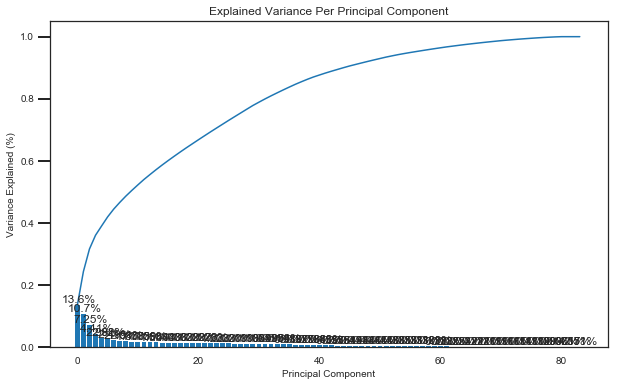

In [54]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 42
pca = PCA(n_components=n_components)
scaler_azdias_clean_subset_pca = pca.fit_transform(scaler_azdias_clean_subset)

In [56]:
# Quick overview
pca_results = pd.DataFrame(scaler_azdias_clean_subset_pca)
pca_results.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,3.845571,-2.870057,-3.006376,-0.735782,-0.796825,2.334710,1.815744,0.798555,-0.633037,-0.767038,...,-0.507165,-1.746371,-1.343292,0.058611,0.084477,0.074082,-0.887415,0.180178,1.090401,-0.047628
1,-0.592871,-0.105170,-3.147995,2.226291,-1.356534,0.522807,-1.216322,-0.549967,0.073245,-1.299212,...,-0.693396,0.553806,0.805538,-0.033149,-1.222791,0.131583,0.146975,-0.353081,-0.434064,-1.036762
2,-4.237087,0.893362,-1.141705,-0.677139,0.346113,1.488326,-0.758261,-0.083018,1.386839,2.442657,...,0.375200,0.123057,-0.570383,1.207292,0.726122,-1.116601,-1.861805,-0.621580,-0.181263,1.271541
3,0.635015,0.612904,3.346948,0.883708,0.528930,-2.597738,2.812758,-2.397112,-0.489412,-0.067038,...,-0.215235,0.254494,0.103267,1.109067,-1.172299,-1.411837,0.518202,-0.059039,0.513365,0.343941
4,-0.844932,-1.093345,-1.047754,-2.789383,-3.721452,-0.096628,-0.588570,0.896328,0.347320,-0.473067,...,-1.090399,-0.957909,-0.578275,1.347211,0.069046,-1.526473,-0.864896,-0.822383,-0.162874,0.705850


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I used the scree plot to take my decision on how many clusters I need to re do my PCA. I found that keeping 42 components will explained 90% of the variance of the scaler_azdias_clean_subset dataset which is acceptable.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_pca_weights(pca, x):
    table = pd.DataFrame(pca.components_, columns=list(scaler_azdias_clean_subset.columns))
    component = table.iloc[x].sort_values()
    return component

In [58]:
#Check weigths for first component
print(get_pca_weights(pca, 1))

SEMIO_REL               -0.244148
decade                  -0.241471
FINANZ_SPARER           -0.234429
SEMIO_TRADV             -0.228671
FINANZ_UNAUFFAELLIGER   -0.224304
SEMIO_PFLICHT           -0.221686
SEMIO_KULT              -0.207140
FINANZ_ANLEGER          -0.204317
SEMIO_FAM               -0.171870
SEMIO_RAT               -0.170655
ONLINE_AFFINITAET       -0.164188
SEMIO_MAT               -0.154963
LP_GROB_1.0             -0.112121
SEMIO_SOZ               -0.095347
LP_GROB_9.0             -0.088727
PLZ8_ANTG1              -0.081930
LP_GROB_11.0            -0.078496
MOBI_REGIO              -0.073608
KBA05_ANTG1             -0.071087
KBA05_GBZ               -0.070955
INNENSTADT              -0.069180
KONSUMNAEHE             -0.064200
PLZ8_GBZ                -0.062650
ANZ_PERSONEN            -0.059834
WL_7.0                  -0.059142
SEMIO_VERT              -0.059054
BALLRAUM                -0.056598
HEALTH_TYP              -0.052815
LP_GROB_7.0             -0.043125
MIN_GEBAEUDEJA

In [59]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#Check weigths for second component
print(get_pca_weights(pca, 2))

ANREDE_KZ               -0.370530
SEMIO_KAEM              -0.337735
SEMIO_DOM               -0.312650
SEMIO_KRIT              -0.276084
SEMIO_RAT               -0.207553
SEMIO_ERL               -0.184819
FINANZ_ANLEGER          -0.180953
FINANZ_SPARER           -0.095275
FINANZ_UNAUFFAELLIGER   -0.089005
decade                  -0.080202
SEMIO_TRADV             -0.068184
SEMIO_PFLICHT           -0.066462
LP_GROB_6.0             -0.053104
FINANZ_HAUSBAUER        -0.049445
movement                -0.049359
ONLINE_AFFINITAET       -0.048722
PLZ8_ANTG1              -0.045888
INNENSTADT              -0.044534
KONSUMNAEHE             -0.038234
PLZ8_GBZ                -0.037670
LP_GROB_1.0             -0.037505
BALLRAUM                -0.036300
LP_GROB_9.0             -0.033624
WL_7.0                  -0.031481
GEBAEUDETYP_RASTER      -0.030359
MOBI_REGIO              -0.025147
KBA13_ANZAHL_PKW        -0.024138
LP_GROB_7.0             -0.023775
KBA05_ANTG1             -0.021503
KBA05_GBZ     

In [60]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#Check weigths for third component
print(get_pca_weights(pca, 3))

movement                     -0.370341
WL_7.0                       -0.243584
HH_EINKOMMEN_SCORE           -0.242329
BALLRAUM                     -0.222702
INNENSTADT                   -0.211188
KKK                          -0.188390
REGIOTYP                     -0.136356
KONSUMNAEHE                  -0.124871
FINANZ_HAUSBAUER             -0.113696
FINANZ_ANLEGER               -0.113352
wealth                       -0.112166
LP_GROB_2.0                  -0.102856
OST_WEST_KZ                  -0.093227
W_KEIT_KIND_HH               -0.074742
KBA05_ANTG3                  -0.065805
GEBAEUDETYP_RASTER           -0.057524
WL_8.0                       -0.049045
PLZ8_ANTG1                   -0.038516
ANZ_HAUSHALTE_AKTIV          -0.035943
ALTERSKATEGORIE_GROB         -0.035494
KBA05_ANTG4                  -0.034693
SEMIO_KULT                   -0.032710
LP_GROB_1.0                  -0.030435
SEMIO_FAM                    -0.028339
LP_GROB_0.9420565708074724   -0.028252
WL_5.0                   

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

We can interpret positive & negative weights together for each component. 


First component : ALTERSKATEGORIE_GROB (negatively correlated) is opposed to decade (positively correlated), this component is therefore positively correlated with decade (increasing it means to be younger), and negatively correlated to ALTERSKATEGORIE_GROB (increasing it means getting older). In the same way, the component is negatively correlated to FINANZ_VORSORGER (increasing it means getting poorer) and SEMIO_LUST ( increasing it means to have a personnality with lower sensual-minded) which are logical with decade (getting younger).

Second component :
We have an opposition between personnality typology. Some personnality are highly negatively correlated with this component (combative attitude, dominant-minded, critical-minded, rational, event-oriented) with other highly positively correlated (materialistic, socially-minded, cultural-minded, family-minded, dreamful).Each group will follow the same trend when moving. It is also really interesting to look at other dimensions moving in the same way. Increasing this component will therefore leads to
be get lower financial interest, and less probability to have children in the house.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

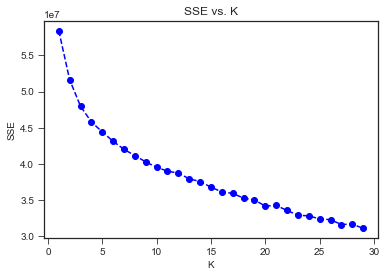

In [61]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,30))

for center in centers:
    scores.append(get_kmeans_score(scaler_azdias_clean_subset_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');    

In [69]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=24)
model_general_population = kmeans.fit(scaler_azdias_clean_subset_pca)

In [70]:
predict_general_population = model_general_population.predict(scaler_azdias_clean_subset_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

We can see on the plot above that there 's no a clear elbow, but still the slope decrease around 24 clusters,  at his stage the score decrease slower. This is this number I chose to re-fit the kmeans model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [71]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

In [72]:
customers.shape

(191652, 85)

In [73]:
customers.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [74]:
customers.dtypes

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
          

In [75]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)

ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
PRAEGENDE_JUGENDJAHRE    float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT                  int64
SEMIO_KRIT                 int64
SEMIO_DOM                  int64
SEMIO_KAEM                 int64
SEMIO_PFLICHT              int64
SEMIO_TRADV                int64
SOHO_KZ                  float64
ANZ_PERSONEN             float64
          

In [76]:
customers.to_csv('customers.csv', sep=';') # Save the data as it takes time to clean the data

In [77]:
customers = pd.read_csv("customers.csv", sep=';') # Load clean customers data

In [78]:
customers.dtypes[customers.dtypes == "object"]

Series([], dtype: object)

In [79]:
# Apply same set up for scaler, PCA and Kmeans to get clusters predictions for customers data

scaler = StandardScaler()
scaler_customers = scaler.fit_transform(customers)
scaler_customers = pd.DataFrame(scaler_customers, columns=list(customers))

n_components = 42
pca = PCA(n_components=n_components)
scaler_customers_pca = pca.fit_transform(scaler_customers)

kmeans = KMeans(n_clusters=24)
model_customers = kmeans.fit(scaler_customers_pca)

predict_customers = model_customers.predict(scaler_customers_pca)

In [80]:
# Check that customers data and general population data have same shape
print (scaler_azdias_clean_subset_pca.shape)
print (scaler_customers_pca.shape)

(787544, 42)
(140271, 42)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [81]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

prop_general_population = []
prop_customers = []
x = [i+1 for i in range(24)]
for i in range(24):
    prop_general_population.append((predict_general_population == i).sum()/len(predict_general_population))
    prop_customers.append((predict_customers == i).sum()/len(predict_customers))
clusters_summary = pd.DataFrame({'cluster' : x,
                                 'prop_general_population' : prop_general_population,
                                 'prop_customers': prop_customers})
clusters_summary['diff'] = clusters_summary['prop_general_population'] - clusters_summary['prop_customers']
clusters_summary.sort_values('diff', ascending=False)


,cluster,prop_general_population,prop_customers,diff
3,4,0.069735,0.008362,0.061372
23,24,0.066325,0.010244,0.056081
9,10,0.040656,0.004242,0.036414
6,7,0.045492,0.012298,0.033194
22,23,0.035673,0.007607,0.028066
13,14,0.065256,0.039217,0.026039
11,12,0.052377,0.027632,0.024745
0,1,0.042263,0.020532,0.021731
21,22,0.020323,0.002060,0.018262
14,15,0.054044,0.035923,0.018121


<Figure size 1800x720 with 0 Axes>

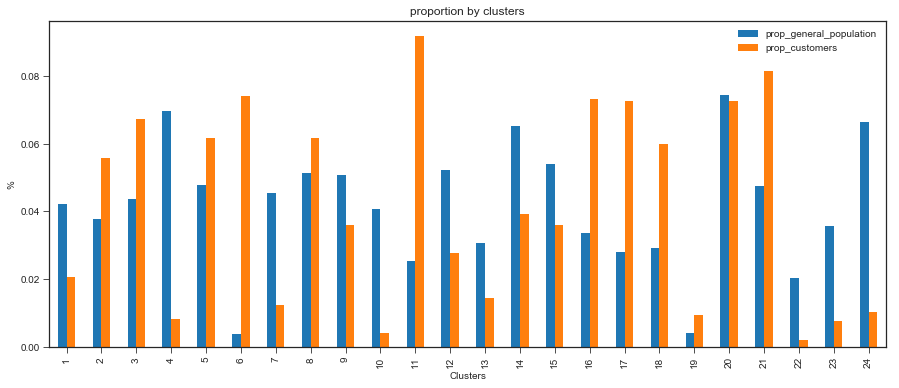

In [82]:
#Plot proportion for each cluster for general population and customers
fig = plt.figure(figsize=(25,10))
sns.set_style("ticks")
ax = clusters_summary.plot(x='cluster', y = ['prop_general_population', 'prop_customers'], kind='bar', figsize=(15,6))
ax.set_title("proportion by clusters")
ax.set_xlabel("Clusters")
ax.set_ylabel("%")
plt.show()

What kinds of people are part of a cluster that is underrepresented in the
customer data compared to the general population?

Cluster 4 is overrepresented in the general population data in regards to customers data.

See figures below concerning cluster 4.

Looking at the major components inside this cluster, we can notice than component 24 is the most intensive ( positive or negative). As it's positive we could directly look at what the component stands for. (If it was negative, we should take the opposite.)


We can see that this one is highly postively correlated with 'LP_GROB_7.0' which tends to single low income families  and 'RELAT_AB',  which tends to have population in county with very high unemployment rate.This component is also negatively correlated with  LP_GROB_6.0  which means tending to more family with 2 parents ( opposite to single parent).


So this cluster, overrepresented in the general population is more about population with low income, family, living with more probability to live in a county where unemployment rate is high.


In [83]:
# Check components for specific center 4
kmeans.cluster_centers_[3]

array([ 1.80890871e+00,  6.82146301e+00,  1.19278446e+00,  6.77319529e-01,
       -1.12373856e+00,  1.01905752e-01,  1.33272010e+00, -1.14010582e+00,
       -4.63506161e-01,  2.25070052e+00, -2.03716972e+00, -1.16585725e+00,
        1.61779738e-04, -4.40345415e-01,  2.75516695e-01,  1.50727050e-01,
       -9.67685560e-01,  2.07158366e-01,  2.30700166e+00,  4.08820785e-01,
       -9.37957470e-01, -3.76729967e-01, -1.21167277e+00, -2.42554863e+00,
        7.63235788e+00,  1.68358801e+00, -2.33434899e+00, -7.55230235e-01,
        1.15754062e+00,  1.27394333e+00,  1.35049144e+00, -1.92994331e+00,
        1.77835093e-01,  5.53806180e-01,  3.80478601e-01,  4.18814285e-01,
        4.12466056e-01, -1.37754536e-01, -1.77032721e-01,  1.88581533e-02,
       -5.28379637e-02,  1.27888517e-01])

In [84]:
# Put it in a dataframe for more visibility
cluster_check = list(kmeans.cluster_centers_[3])
list_components = list(range(0,n_components))
cluster_check = pd.DataFrame({'Component':list_components, 'Center': cluster_check})
cluster_check.sort_values('Center',ascending=False)

,Component,Center
24,24,7.632358
1,1,6.821463
18,18,2.307002
9,9,2.250701
0,0,1.808909
25,25,1.683588
30,30,1.350491
6,6,1.332720
29,29,1.273943
2,2,1.192784


In [85]:
n_components = 42
pca = PCA(n_components=n_components)
scaler_azdias_clean_subset_pca = pca.fit_transform(scaler_azdias_clean_subset)

In [86]:
#Check component 24
print(get_pca_weights(pca, 24))

LP_GROB_6.0                  -0.318569
KBA05_ANTG3                  -0.160238
WL_8.0                       -0.156809
LP_GROB_0.9420565708074724   -0.148033
HEALTH_TYP                   -0.139072
LP_GROB_10.0                 -0.127350
WOHNDAUER_2008               -0.090551
OST_WEST_KZ                  -0.082561
LP_GROB_9.0                  -0.080498
LP_GROB_8.0                  -0.079814
LP_GROB_12.0                 -0.078941
WL_1.0                       -0.076077
LP_GROB_1.0                  -0.069533
LP_GROB_4.0                  -0.067910
ANZ_TITEL                    -0.067665
life_stage                   -0.065219
RETOURTYP_BK_S               -0.063542
KKK                          -0.054587
WL_5.0                       -0.051763
GREEN_AVANTGARDE             -0.050975
SEMIO_SOZ                    -0.047933
GEBAEUDETYP_RASTER           -0.044569
FINANZ_ANLEGER               -0.040352
REGIOTYP                     -0.034377
KONSUMNAEHE                  -0.033123
KBA13_ANZAHL_PKW         

What kinds of people are part of a cluster that is overrepresented in the
customer data compared to the general population?

Cluster 6 is overrepresented in the customers data in regards to general population data.

See figures below concerning cluster 6.

Looking at the major components inside this cluster, we can notice than component 7 is postively intense.
We can see that this component is higly negatively correlated with KBA05_ANTG3, KBA05_ANTG2 which tends to have lower number family in the microcell but higly positively correlated with ANZ_HAUSHALTE_AKTIV, which means tending to have a lot of households in the building and 'REGIOTYPE' which tends to have marginal groups in neighborhood.

In [87]:
# Check components for specific center 6
kmeans.cluster_centers_[5]

array([-2.25182001, -0.95072121,  0.71026253,  0.50244176, -1.69726173,
       -0.36832308,  0.78466491,  0.75371125,  0.68477862, -0.55166046,
       -0.02338819,  0.07499891,  0.14491026, -0.34952313, -0.29499829,
        0.37710564, -0.42574447, -0.08643585, -0.23167076,  0.10671398,
       -0.06573698, -0.06541577, -0.08828266, -0.15842496, -0.05624208,
        0.05696008, -0.1143942 , -0.31986018, -0.10202137,  0.21066384,
       -0.16527352, -0.18633772, -0.124951  ,  0.04393116, -0.03949899,
       -0.11022891, -0.18956814,  0.01483006, -0.05373757, -0.01948955,
       -0.05882914,  0.22394225])

In [88]:
# Put it in a dataframe for more visibility
cluster_check = list(kmeans.cluster_centers_[5])
list_components = list(range(0,n_components))
cluster_check = pd.DataFrame({'Component':list_components, 'Center': cluster_check})
cluster_check.sort_values('Center',ascending=False)

,Component,Center
6,6,0.784665
7,7,0.753711
2,2,0.710263
8,8,0.684779
3,3,0.502442
15,15,0.377106
41,41,0.223942
29,29,0.210664
12,12,0.144910
19,19,0.106714


In [91]:
#Check component 7
print(get_pca_weights(pca, 7))

KBA05_ANTG3                  -0.348275
KBA05_ANTG2                  -0.346858
MIN_GEBAEUDEJAHR             -0.269486
PLZ8_ANTG2                   -0.206465
WL_8.0                       -0.187044
GEBAEUDETYP_RASTER           -0.158547
WL_0.0                       -0.129280
ARBEIT                       -0.117939
RELAT_AB                     -0.114719
PLZ8_ANTG3                   -0.105642
BALLRAUM                     -0.097192
LP_GROB_8.0                  -0.080724
INNENSTADT                   -0.066228
SEMIO_MAT                    -0.063215
LP_GROB_10.0                 -0.062148
OST_WEST_KZ                  -0.059058
HEALTH_TYP                   -0.056699
ONLINE_AFFINITAET            -0.055083
SEMIO_VERT                   -0.054756
LP_GROB_6.0                  -0.052716
LP_GROB_4.0                  -0.050116
movement                     -0.044211
decade                       -0.041431
LP_GROB_7.0                  -0.041331
WL_3.0                       -0.041058
WL_1.0                   

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Analysis provided above
------

What kinds of people are part of a cluster that is underrepresented in the
customer data compared to the general population?

Cluster 4 is overrepresented in the general population data in regards to customers data.

See figures below concerning cluster 4.

Looking at the major components inside this cluster, we can notice than component 24 is the most intensive ( positive or negative). As it's positive we could directly look at what the component stands for. (If it was negative, we should take the opposite.)


We can see that this one is highly postively correlated with 'LP_GROB_7.0' which tends to single low income families  and 'RELAT_AB',  which tends to have population in county with very high unemployment rate.This component is also negatively correlated with  LP_GROB_6.0  which means tending to more family with 2 parents ( opposite to single parent).


So this cluster, overrepresented in the general population is more about population with low income, family, living with more probability to live in a county where unemployment rate is high.



What kinds of people are part of a cluster that is overrepresented in the
customer data compared to the general population?

Cluster 6 is overrepresented in the customers data in regards to general population data.

See figures below concerning cluster 6.

Looking at the major components inside this cluster, we can notice than component 7 is postively intense.
We can see that this component is higly negatively correlated with KBA05_ANTG3, KBA05_ANTG2 which tends to have lower number family in the microcell but higly positively correlated with ANZ_HAUSHALTE_AKTIV, which means tending to have a lot of households in the building and 'REGIOTYPE' which tends to have marginal groups in neighborhood.


Summary
------

As mentionned in the clusters description (4 & 6) above , a segment of the population relatively popular with the mail-order company is people living in rural population, at least in area with no dense population, more likely single and wealthier than average population.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.